In [8]:
import pythetatools.toyxp as toyxp
import pythetatools.likelihood as likelihood
from pythetatools.global_names import *
from pythetatools.base_visualisation import *
from pythetatools.file_manager import read_histogram, download
from pythetatools.base_analysis import critical_value_for_cl, get_critical_values, find_intersections

from scipy.interpolate import interp1d
import shutil
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import uproot
import matplotlib.colors as colors
from matplotlib.ticker import LogLocator, NullFormatter
import pandas as pd

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use(t2k_style)

In [2]:
%load_ext autoreload
%autoreload 2

In [13]:
#For OA2023 data-fit #From PTBestFit; read the ROOT file instead
best_fit = {'dm2':    {0: 2.521e-3,  1: 2.486e-3},  
            'sin213': {0: 21.9e-3,   1: 22.0e-3},
            'delta':  {0: -2.08,     1: -1.41},
            'sin223': {0: 568.9e-3,  1: 0.567},
           }

In [58]:
param = 'sin223'

if param == 'sin2213':
    basename_directory="MargTemplates_DataFit_sin2213_100k_p-theta_mode_0"
else:
    basename_directory = f"MargTemplates_fit_DataRun1_11_fit_data23RC_FullSyst_wRC_etheta_ptheta_{param}"
dir_ver = 'OA2023'

file_pattern = f"{inputs_dir}/{dir_ver}/MargTemplates/{basename_directory}/marg*.root"

grid, avnllh, param_name = likelihood.load(file_pattern)
grid, param_name = likelihood.transform_s2213_to_sin213(grid, param_name)
llh = likelihood.Loglikelihood(grid, avnllh, param_name, kind='joint')
param_name_x = param_name[0]
grid_x = grid[0]

Number of entries in 'MargTemplate': 3240.
Grid sizes: [81] for parameters ['sin223']
Tranformation will not be done as in your param_name there is not sin2213


(0.0, 30.0)

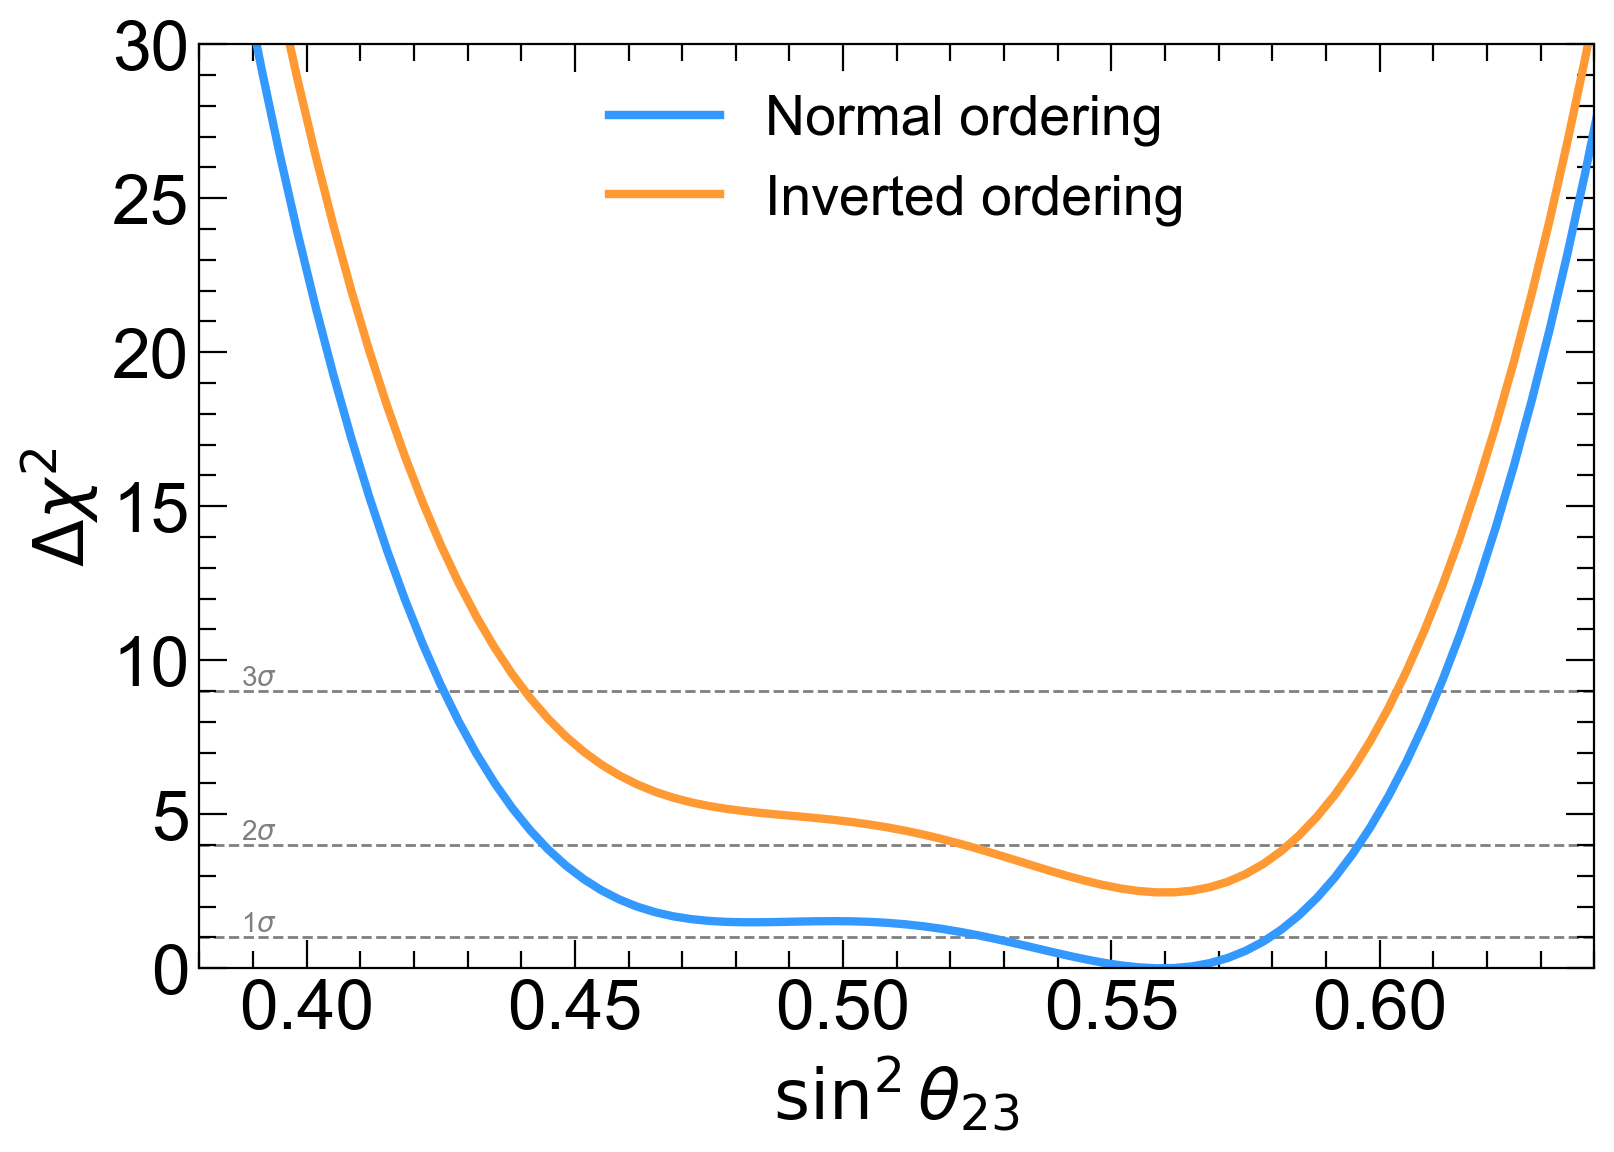

In [59]:
fig, ax = plt.subplots()
llh.plot(ax)
plt.ylim(0, 30)

In [60]:
sigma_ranges = {}
sigma_minus_plus = {}
nsigmas = [1, round(critical_value_for_cl(0.90, 1), 4), 2, 3]
FC = True

if FC:
    crit_val_central_NO = get_critical_values(param_name_x, true_param_grid_sorted[param_name_x], 0, outputs_dir, dir_ver)
    crit_val_central_IO = get_critical_values(param_name_x, true_param_grid_sorted[param_name_x], 1, outputs_dir, dir_ver)
    critical_values=[crit_val_central_NO, crit_val_central_IO]
    
    for mh in [0, 1]:
        sigma_ranges_thismh = {}
        for level in critical_values[0].keys():
            x_inter = find_intersections(llh.grid[0], llh.dchi2[mh], true_param_grid_sorted[param_name_x], critical_values[mh][level])
            sigma_ranges_thismh[level] = x_inter
        sigma_ranges[mh] = sigma_ranges_thismh
        sigma_minus_plus_thismh = {}
        for level in sigma_ranges[mo].keys():
            sigma_minus_plus_thismh[level] = sigma_ranges[mh][level] - best_fit[param_name_x][mh]
        sigma_minus_plus[mh] = sigma_minus_plus_thismh
else:
     for mh in [0, 1]:
        sigma_ranges_thismh = {}
        for nsigma in nsigmas:
            sigma_ranges_thismh[nsigma] = llh.find_CI(nsigma, mo=mh)
        sigma_ranges[mh] = sigma_ranges_thismh
         
        sigma_minus_plus_thismh = {}
        for nsigma in nsigmas:
            sigma_minus_plus_thismh[nsigma] = sigma_ranges[mh][nsigma] - best_fit[param_name_x][mh]
        sigma_minus_plus[mh] = sigma_minus_plus_thismh



In [61]:
from pprint import pprint
print('Ranges:')
pprint(sigma_ranges, sort_dicts=False)
print('+-Sigmas')
pprint(sigma_minus_plus, sort_dicts=False)

Ranges:
{0: {0.6827: array([0.465, 0.481, 0.532, 0.582]),
     0.9: array([0.444, 0.592]),
     0.9545: array([0.436, 0.597]),
     0.9973: array([0.42 , 0.611])},
 1: {0.6827: array([], dtype=float64),
     0.9: array([0.53 , 0.585]),
     0.9545: array([0.468, 0.592]),
     0.9973: array([0.431, 0.608])}}
+-Sigmas
{0: {0.6827: array([-0.1039, -0.0879, -0.0369,  0.0131]),
     0.9: array([-0.1249,  0.0231]),
     0.9545: array([-0.1329,  0.0281]),
     0.9973: array([-0.1489,  0.0421])},
 1: {0.6827: array([], dtype=float64),
     0.9: array([-0.037,  0.018]),
     0.9545: array([-0.099,  0.025]),
     0.9973: array([-0.136,  0.041])}}
